In [106]:
import pandas as pd
from pathlib import Path  
import sys
import sqlite3

CUT_OF_UNIQUE_VALUES=40

In [107]:
data_filtered_cedd=pd.read_csv("cleaned_data_with_binary_dead.csv")
df_counts  = pd.DataFrame(columns = ['col', 'count'])
for col in data_filtered_cedd:
    no_of_unique_values=data_filtered_cedd[col].nunique()
    df_counts.loc[len(df_counts)]=[col,no_of_unique_values]
#     if( not col.startswith( 'Unnamed' ) && no_of_unique_values<20):
#         print("%s--->%s"%(col,))
df_counts = df_counts.sort_values(by=['count'], ascending=False)
display(df_counts.head(30))

count=0

for col in data_filtered_cedd:
    no_of_unique_values=data_filtered_cedd[col].nunique()
    if( not col.startswith( 'Unnamed' ) and no_of_unique_values<40):
        count =count+1
        #data_filtered_cedd[col].fillna("imputed",inplace=True)
        data_filtered_cedd[col]=pd.Categorical(data_filtered_cedd[col])
                
data_filtered_cedd.dtypes.value_counts()



count


    



C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (75,83,88,136) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,col,count
0,Unnamed: 0,28122
2,Unnamed: 0.1.1,28122
1,Unnamed: 0.1,28122
29,ceo_id,15744
28,epi_id,7432
4,pa_id,5930
13,epi_SocDate,1056
22,icd_code,967
23,icd_code_description,965
14,epi_StartOfEpisode,833


133

In [108]:
from datetime import timedelta

##### adding our binary, "amIdead?" column
df = data_filtered_cedd
df['amIdead?'] = np.where((df['DaysToDeath'] <= 365) | (df['dcc_desc'] == 'PATIENT EXPIRED'), 1, 0)
##### defining our year threshold, and converting neccesary col's to datetimes

threesixtyfive = timedelta(days = 365)

df['epi_SocDate'] = pd.to_datetime(df['epi_SocDate'])
df['epi_EndOfEpisode'] = pd.to_datetime(df['epi_EndOfEpisode'])
##### dropping all 'alive' patients with LESS than a year of history

for index, row in df.iterrows():
    if row['amIdead?'] == 0 and row['epi_EndOfEpisode'] - row['epi_SocDate'] < threesixtyfive:
        df.drop(index, axis = 0, inplace = True)
        
##### dropping all 'dead' patients with MORE than a year of history

for index, row in df.iterrows():
    if row['amIdead?'] == 1 and row['epi_EndOfEpisode'] - row['epi_SocDate'] > threesixtyfive:
        df.drop(index, axis = 0, inplace = True)

In [109]:
data_filtered_cedd = df

data_filtered_cedd["M1056_PVX_RSN_NOT_RCVD_AGNCY"].cat.categories
data_filtered_cedd.groupby(['M1056_PVX_RSN_NOT_RCVD_AGNCY']).size()

data_filtered_cedd["M1200_VISION"].cat.categories
data_filtered_cedd.groupby(['M1200_VISION']).size()

M1200_VISION
0 - NORMAL VISION: SEES ADEQUATELY IN MOST SITUATIONS; CAN SEE MEDICATION LABELS, NEWSPRINT                                                                        5141
1 - PARTIALLY IMPAIRED: CANNOT SEE MEDICATION LABELS OR NEWSPRINT, BUT CAN SEE OBSTACLES IN PATH, AND THE SURROUNDING LAYOUT; CAN COUNT FINGERS AT ARM'S LENGTH    1803
2 - SEVERELY IMPAIRED: CANNOT LOCATE OBJECTS WITHOUT HEARING OR TOUCHING THEM OR PATIENT NONRESPONSIVE                                                               87
dtype: int64

### Drop columns with no meaning

In [110]:
data_filtered_cedd = data_filtered_cedd.drop(columns=['CreatedDate', 'CreatedBy', 'UpdateDate', 'UpdateBy', 'ActiveFlag'])

In [111]:
data_filtered_cedd['DaysToDeath']

40       194.0
41       194.0
42       194.0
43       194.0
76        12.0
         ...  
28117      2.0
28118      2.0
28119      2.0
28120      2.0
28121      2.0
Name: DaysToDeath, Length: 12676, dtype: float64

### Find columns with name ID

In [112]:
[col for col in data_filtered_cedd.columns if 'id' in col]

['pa_id', 'epi_dcrid', 'epi_id', 'ceo_id']

In [113]:
[col for col in data_filtered_cedd.columns if 'Id' in col]

['DispositionId', 'amIdead?']

### Drop ID columns

In [114]:
df = data_filtered_cedd.drop(columns=['DispositionId', 'pa_id', 'epi_dcrid', 'epi_id', 'ceo_id'])

### Drop records with DaysToDeath = 0

In [115]:
df.dropna(subset=['DaysToDeath'])

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,year_born,pa_race,pa_gender,pa_maritalstatus,epi_AdmitType,dcc_desc,dcr_desc,...,M2310_ECR_UNKNOWN,M2401_INTRVTN_SMRY_DBTS_FT,M2401_INTRVTN_SMRY_DPRSN,M2401_INTRVTN_SMRY_FALL_PRVNT,M2401_INTRVTN_SMRY_PAIN_MNTR,M2401_INTRVTN_SMRY_PRSULC_PRVN,M2401_INTRVTN_SMRY_PRSULC_WET,M2410_INPAT_FACILITY,M2420_DSCHRG_DISP,amIdead?
40,40,40,40,1930,NaN,MALE,NaN,RECERTIFICATION,PATIENT EXPIRED,PATIENT EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
41,41,41,41,1930,NaN,MALE,NaN,RECERTIFICATION,PATIENT EXPIRED,PATIENT EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
42,42,42,42,1930,NaN,MALE,NaN,RECERTIFICATION,PATIENT EXPIRED,PATIENT EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
43,43,43,43,1930,NaN,MALE,NaN,RECERTIFICATION,PATIENT EXPIRED,PATIENT EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
76,76,76,76,1966,NaN,FEMALE,NaN,NEW ADMISSION,PATIENT EXPIRED,PATIENT EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28117,28117,28117,28117,1940,NaN,FEMALE,NaN,NEW ADMISSION,PATIENT EXPIRED,PATIENT EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
28118,28118,28118,28118,1940,NaN,FEMALE,NaN,NEW ADMISSION,PATIENT EXPIRED,PATIENT EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
28119,28119,28119,28119,1940,NaN,FEMALE,NaN,NEW ADMISSION,PATIENT EXPIRED,PATIENT EXPIRED,...,NO,NA - PATIENT IS NOT DIABETIC OR IS MISSING LOW...,NA - (C2) PATIENT HAS NO DIAGNOSIS OF DEPRESSI...,1 - YES,1 - YES,1 - YES,NA - PATIENT HAS NO PRESSURE ULCERS OR HAS NO ...,1 - HOSPITAL,NaN,1
28120,28120,28120,28120,1940,NaN,FEMALE,NaN,NEW ADMISSION,PATIENT EXPIRED,PATIENT EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [116]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df.select_dtypes(include=numerics)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,year_born,epi_height,epi_weight,DaysToDeath,RoughAge,amIdead?
40,40,40,40,1930,NaN,NaN,194.0,NaN,1
41,41,41,41,1930,NaN,NaN,194.0,NaN,1
42,42,42,42,1930,NaN,NaN,194.0,NaN,1
43,43,43,43,1930,NaN,NaN,194.0,NaN,1
76,76,76,76,1966,NaN,NaN,12.0,NaN,1
...,...,...,...,...,...,...,...,...,...
28117,28117,28117,28117,1940,NaN,NaN,2.0,82.0,1
28118,28118,28118,28118,1940,NaN,NaN,2.0,82.0,1
28119,28119,28119,28119,1940,NaN,NaN,2.0,82.0,1
28120,28120,28120,28120,1940,NaN,NaN,2.0,82.0,1


### Drop columns that are giving hints as response variables (like cedd_dateofdeath).

In [ ]:
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])

In [119]:
### Also drop dcc_desc and dcr_desc

In [118]:
df.drop(['M2200_THER_NEED_NBR', 'M1322_NBR_PRSULC_STG1', 'M0090_INFO_COMPLETED_DT', 'ceo_OASIScorrectionnum', 'DaysToDeath', 'cedd_dateofdeath', 'ceas_ascode', 'epi_DischargeDate', 'epi_EndOfEpisode', 'epi_StartOfEpisode', 'epi_SocDate', 'dcr_desc', 'dcc_desc'], inplace = True, axis = 1)

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import numpy as np

imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='imputed')
idf = pd.DataFrame(imputer.fit_transform(df))
idf.columns=df.columns
# idf.index=df.index

#
df = idf
for col in df:
    no_of_unique_values=df[col].nunique()
    if( not col.startswith( 'Unnamed' ) and no_of_unique_values<40):        
        df[col]=pd.Categorical(df[col])

In [121]:
df.dtypes

year_born                           object
pa_race                           category
pa_gender                         category
pa_maritalstatus                  category
epi_AdmitType                     category
                                    ...   
M2401_INTRVTN_SMRY_PRSULC_PRVN    category
M2401_INTRVTN_SMRY_PRSULC_WET     category
M2410_INPAT_FACILITY              category
M2420_DSCHRG_DISP                 category
amIdead?                          category
Length: 130, dtype: object

#### detect columns that contain numeric value when it shouldn't be. (This runs quite a long time)

In [122]:
for column_name in df.columns:
    if column_name != 'year_born':
        for index, row in df.iterrows():
            if isinstance(row[column_name], (int, float)):
                print(column_name)
                df[column_name] = df[column_name].astype(str)
                break

pa_race
pa_maritalstatus
epi_height
epi_weight
RoughAge
M1311_NBR_ULC_SOCROC_STG2_A2
M1311_NBR_ULC_SOCROC_STG3_B2
M1311_NBR_ULC_SOCROC_STG4_C2
M1311_NSTG_CVRG_SOCROC_E2
M1311_NSTG_DEEP_TSUE_SOCROC_F2
M1311_NSTG_DRSG_SOCROC_D2
amIdead?


In [123]:
# Use Ordinal Encoder for all numeric type category

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(df)
enc.categories_

[array([1909, 1914, 1915, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924,
        1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935,
        1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
        1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
        1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
        1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
        1980, 1981, 1982, 1983, 1984, 1985, 1988, 1989, 1990, 1993, 1996,
        1999, 2011], dtype=object),
 array(['1.0', '2.0', '3.0', '5.0', '6.0', 'imputed'], dtype=object),
 array(['FEMALE', 'MALE  '], dtype=object),
 array(['1.0', '2.0', '25000.0', '3.0', '4.0', '5.0', '6.0', '8.0',
        'imputed'], dtype=object),
 array(['NEW ADMISSION', 'READMISSION', 'RECERTIFICATION'], dtype=object),
 array(['5.0', '5.3', '5.6', '55.0', '56.25', '57.0', '59.0', '59.8',
        '60.0', '60.5', '60.98', '61.0', '61.2', '61.96', '61.97', '62.0',
        '

In [124]:
xdf = enc.transform(df) # transform using encoder

In [125]:
df2 = pd.DataFrame(xdf, columns=df.columns) # numpy to dataframe

In [126]:
X = df2.iloc[:,:-1]

In [127]:
y = df2.iloc[:,-1:]

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)

### Feature Selection: LASSO

In [129]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

lasso_model = LassoCV().fit(X, y)

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1572: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [130]:
sfm = SelectFromModel(lasso_model, threshold=0.05)
sfm.fit(X_train, y_train)
sfm.transform(X_train).shape[1]

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1572: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1

In [131]:
while n_features > 5:
    sfm.threshold += 0.1
    X_transform = sfm.transform(X_train)
    n_features = X_transform.shape[1]

In [132]:
importance = np.abs(lasso_model.coef_)
idx_third = importance.argsort()[-10]
threshold = importance[idx_third] + 0.01

idx_features = (-importance).argsort()[:10]
name_features = np.array(X_train.columns)[idx_features]
print('Selected features: {}'.format(name_features))

Selected features: ['epi_AdmitType' 'M1340_SRGCL_WND_PRSNT']


In [ ]:
df.columns[:-1][np.abs(lasso_model.coef_) > 0]

In [154]:
sorted({df.columns[:-1][i]: abs(v) for i, v in enumerate(lasso_model.coef_) if abs(v) > 0}, key=lambda e: e[1])

['M0100_ASSMT_REASON',
 'M0906_DC_TRAN_DTH_DT',
 'M1046_INFLNZ_RECD_CRNT_SEASON',
 'M1060_HEIGHT_A',
 'M1060_WEIGHT_B',
 'M1324_STG_PRBLM_ULCER',
 'M1330_STAS_ULCR_PRSNT',
 'M1332_NBR_STAS_ULCR',
 'M1340_SRGCL_WND_PRSNT',
 'M1400_WHEN_DYSPNEIC',
 'M1600_UTI',
 'M1620_BWL_INCONT',
 'M1810_CRNT_DRESS_UPPER',
 'M1845_CRNT_TOILTG_HYGN',
 'M1850_CRNT_TRNSFRNG',
 'M1870_CRNT_FEEDING',
 'M2030_CRNT_MGMT_INJCTN_MDCTN',
 'M2410_INPAT_FACILITY',
 'pa_race',
 'pa_maritalstatus',
 'icd_code',
 'icd_code_description',
 'year_born',
 'ceo_HIPPS',
 'ceo_HHRG',
 'DiagnosisCategory',
 'RoughAge',
 'epi_AdmitType',
 'epi_height',
 'epi_weight']

In [186]:
len(lasso_model.coef_)

129

### Misc Facts about data

#### some columns have '-' as category

In [ ]:
df.M1028_ACTV_DIAG_DM.unique() 

In [ ]:
df.M1028_ACTV_DIAG_PVD_PAD.unique() 

In [ ]:
df.M2003_MDCTN_FLWP.unique() 

#### some columns represent single variable type, some are over multiple columns

In [ ]:
list(df.M1400_WHEN_DYSPNEIC.unique())

In [ ]:
list(df.M1033_HOSP_RISK_MLTPL_HOSPZTN.unique())

### Feature Evaluation using Regression

In [156]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

names=pd.DataFrame(X_train.columns)

lin_reg = LogisticRegression()

rfe_mod = RFE(lin_reg, n_features_to_select=5, step=1)

fit_model = rfe_mod.fit(X_train, y_train)
fit_model.support_
fit_model.ranking_

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

array([ 93,  63,  92,  65,   1, 114, 116,  96,  73, 124, 123,  41,  17,
       104,  94,  47,  51,  77,  60,  58, 122, 110,  78,  23,  50,  42,
        18,  56,  54,   4, 125, 119, 113,   1,  40,   3,  20, 107,  95,
        97, 109,  22,   7, 100,   1, 112,   1,  82,  80,  76, 106,  87,
        62,  98,  32,  52,   9,  39, 120,  38,  37,  10,   1, 117,  14,
        43,   8, 118,  11, 115,  36,  67,  34,  27,  74,  64,   6,  86,
        33,  66, 103, 108,  84,  99, 101,  31,  46,  75,  49,  44,  48,
        30,  59,  85,  13,  12, 105,  79,  57,  25,  35,  89,  68,  16,
        91,  15,  55, 111,  26, 121,  83,  24,  19,  71,  72,  29,  69,
        90,  88,  53, 102,  61,  28,   2,  70,  81,  45,  21,   5])

In [157]:
selected_features = []
for i, rank in enumerate(fit_model.ranking_):
    feature = fit_model.feature_names_in_[i]
    selected_features.append({'feature': feature, 'rank': rank})
selected_features

[{'feature': 'year_born', 'rank': 93},
 {'feature': 'pa_race', 'rank': 63},
 {'feature': 'pa_gender', 'rank': 92},
 {'feature': 'pa_maritalstatus', 'rank': 65},
 {'feature': 'epi_AdmitType', 'rank': 1},
 {'feature': 'epi_height', 'rank': 114},
 {'feature': 'epi_weight', 'rank': 116},
 {'feature': 'ceo_HIPPS', 'rank': 96},
 {'feature': 'ceo_HHRG', 'rank': 73},
 {'feature': 'icd_code', 'rank': 124},
 {'feature': 'icd_code_description', 'rank': 123},
 {'feature': 'DiagnosisCategory', 'rank': 41},
 {'feature': 'RoughAge', 'rank': 17},
 {'feature': 'M0100_ASSMT_REASON', 'rank': 104},
 {'feature': 'M0110_EPISODE_TIMING', 'rank': 94},
 {'feature': 'M0140_ETHNIC_AI_AN', 'rank': 47},
 {'feature': 'M0140_ETHNIC_ASIAN', 'rank': 51},
 {'feature': 'M0140_ETHNIC_BLACK', 'rank': 77},
 {'feature': 'M0140_ETHNIC_HISP', 'rank': 60},
 {'feature': 'M0140_ETHNIC_NH_PI', 'rank': 58},
 {'feature': 'M0140_ETHNIC_WHITE', 'rank': 122},
 {'feature': 'M0906_DC_TRAN_DTH_DT', 'rank': 110},
 {'feature': 'M1000_DC_IP

In [158]:
sorted(selected_features, key=lambda i: i['rank'])

[{'feature': 'epi_AdmitType', 'rank': 1},
 {'feature': 'M1030_THH_ENT_NUTRITION', 'rank': 1},
 {'feature': 'M1033_HOSP_RISK_NONE_ABOVE', 'rank': 1},
 {'feature': 'M1033_HOSP_RISK_WEIGHT_LOSS', 'rank': 1},
 {'feature': 'M1311_NBR_ULC_SOCROC_STG4_C2', 'rank': 1},
 {'feature': 'M2401_INTRVTN_SMRY_FALL_PRVNT', 'rank': 2},
 {'feature': 'M1030_THH_NONE_ABOVE', 'rank': 3},
 {'feature': 'M1000_DC_SNF_14_DA', 'rank': 4},
 {'feature': 'M2420_DSCHRG_DISP', 'rank': 5},
 {'feature': 'M1600_UTI', 'rank': 6},
 {'feature': 'M1033_HOSP_RISK_MLTPL_HOSPZTN', 'rank': 7},
 {'feature': 'M1311_NSTG_DEEP_TSUE_SOCROC_F2', 'rank': 8},
 {'feature': 'M1307_OLDST_STG2_ONST_DT', 'rank': 9},
 {'feature': 'M1311_NBR_ULC_SOCROC_STG3_B2', 'rank': 10},
 {'feature': 'M1311_NSTG_DRSG_SOCROC_D2', 'rank': 11},
 {'feature': 'M1810_CRNT_DRESS_UPPER', 'rank': 12},
 {'feature': 'M1800_CRNT_GROOMING', 'rank': 13},
 {'feature': 'M1311_NSTG_CVRG_SOCROC_E2', 'rank': 14},
 {'feature': 'M2003_MDCTN_FLWP', 'rank': 15},
 {'feature': 'M

In [159]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)


model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_train)

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [168]:
## !pip install statsmodels

You should consider upgrading via the 'C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [171]:
import statsmodels.api as sm
def get_stats():
    #x = df[df.columns[:-1]]
    results = sm.OLS(y_train, X_train).fit()
    print(results.summary())
get_stats()

                                 OLS Regression Results                                
Dep. Variable:               amIdead?   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              2558.
Date:                Tue, 12 Apr 2022   Prob (F-statistic):                        0.00
Time:                        15:05:51   Log-Likelihood:                          3738.5
No. Observations:                9507   AIC:                                     -7219.
Df Residuals:                    9378   BIC:                                     -6295.
Df Model:                         129                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [182]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
def get_models():
    models = dict()
    for i in range(2, 10):
        rfe = RFE(estimator=LogisticRegression(), n_features_to_select=i)
        model = LogisticRegression()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

In [183]:
models = get_models()

In [184]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

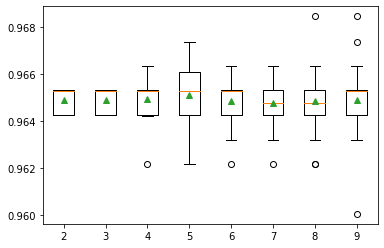

In [185]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)    
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [188]:
results

[array([0.96424816, 0.96424816, 0.96424816, 0.96424816, 0.96529968,
        0.96529968, 0.96529968, 0.96526316, 0.96526316, 0.96526316,
        0.96424816, 0.96424816, 0.96424816, 0.96424816, 0.96529968,
        0.96529968, 0.96529968, 0.96526316, 0.96526316, 0.96526316,
        0.96424816, 0.96529968, 0.96424816, 0.96424816, 0.96529968,
        0.96529968, 0.96529968, 0.96526316, 0.96526316, 0.96526316]),
 array([0.96424816, 0.96424816, 0.96424816, 0.96424816, 0.96529968,
        0.96529968, 0.96529968, 0.96526316, 0.96526316, 0.96526316,
        0.96424816, 0.96424816, 0.96424816, 0.96424816, 0.96529968,
        0.96529968, 0.96529968, 0.96526316, 0.96526316, 0.96526316,
        0.96424816, 0.96529968, 0.96424816, 0.96424816, 0.96529968,
        0.96529968, 0.96529968, 0.96526316, 0.96526316, 0.96526316]),
 array([0.96424816, 0.96424816, 0.96424816, 0.96424816, 0.96529968,
        0.96529968, 0.96529968, 0.96526316, 0.96526316, 0.96526316,
        0.96424816, 0.96424816, 0.96214511, 